In [163]:
import sys
sys.path.insert(0, '..')

# Obtención de reportes

In [164]:
import controllers as c

In [165]:
reports = c.get_reports(limit=900)
len(reports), reports[:5]

(900,
  <models.Report at 0x7f2e494739a0>])

In [166]:
columns = [c for c in list(reports[0].__dict__.keys()) if c != '_id']
columns

['report_id',
 'creation_time',
 'status',
 'component',
 'dupe_of',
 'summary',
 'comments']

In [167]:
import pandas as pd

df_reports = pd.DataFrame(columns=columns, data=[r.__dict__ for r in reports])
df_reports.head()

,report_id,creation_time,status,component,dupe_of,summary,comments
0,1775851,2022-06-22 20:30:23,NEW,New Tab Page,NaN,Intermittent browser/components/newtab/test/br...,
1,1775776,2022-06-22 20:08:18,NEW,Protections UI,NaN,Intermittent browser/components/protections/te...,
2,1775671,2022-06-22 19:38:28,NEW,Toolbars and Customization,NaN,Intermittent browser/components/customizableui...,
3,1775632,2022-06-22 19:28:36,NEW,Tabbed Browser,NaN,Intermittent browser/base/content/test/perform...,
4,1771460,2022-05-27 09:21:04,RESOLVED,General,NaN,Conflicting global variable and lazy getter,There are some case that `Services` is importe...


In [168]:
df_reports.dtypes

report_id                 int64
creation_time    datetime64[ns]
status                   object
component                object
dupe_of                 float64
summary                  object
comments                 object
dtype: object

In [169]:
df_reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   report_id      900 non-null    int64         
 1   creation_time  900 non-null    datetime64[ns]
 2   status         900 non-null    object        
 3   component      900 non-null    object        
 4   dupe_of        329 non-null    float64       
 5   summary        900 non-null    object        
 6   comments       900 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 49.3+ KB


## Eliminar duplicados sin maestro

In [170]:
import numpy as np

In [171]:
print(f"Número de reportes antes de eliminar duplicados sin maestro: {len(df_reports)}")

for i, r in df_reports.iterrows():
    if str(r['dupe_of']) != "nan":
        try:
            c.get_report(r['dupe_of'])
        except Exception as e:
            df_reports.drop(i, inplace=True)

print(f"Número de reportes después de eliminar duplicados sin maestro: {len(df_reports)}")

Número de reportes antes de eliminar duplicados sin maestro: 900
Número de reportes después de eliminar duplicados sin maestro: 892


# Valores nulos

In [172]:
# Get percentage of empty strings in summary and comments
df_empty_values = pd.DataFrame()
df_empty_values['summary'] = [s == '' for s in df_reports['summary']]
df_empty_values['comments'] = [s == '' for s in df_reports['comments']]
df_empty_values['status'] = [s == '' for s in df_reports['status']]
df_empty_values['component'] = [s == '' for s in df_reports['component']]
df_empty_values['dupe_of'] = [s == '' for s in df_reports['dupe_of']]
df_empty_values['report_id'] = [s == '' for s in df_reports['report_id']]

In [173]:
df_empty_values.sample(5)

,summary,comments,status,component,dupe_of,report_id
587,False,False,False,False,False,False
495,False,False,False,False,False,False
662,False,False,False,False,False,False
498,False,False,False,False,False,False
335,False,False,False,False,False,False


In [ ]:
# count true values in each column
df_empty_values.sum()

summary       0
comments     26
status        0
component     0
dupe_of       0
report_id     0
dtype: int64

# Graficar las variables disponibles

## Distribución de duplicados y maestros

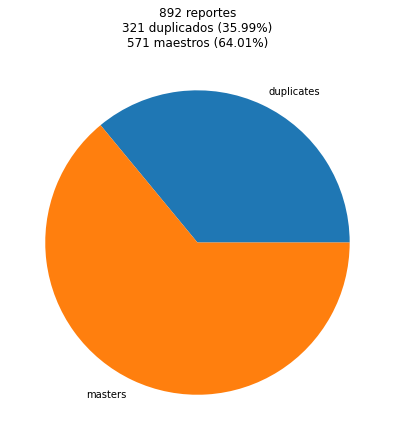

In [174]:
import matplotlib.pyplot as plt

n_masters = len(df_reports[df_reports['dupe_of'].isnull()])
n_duplicates = len(df_reports[df_reports['dupe_of'].notnull()])
n_reports = len(df_reports)


plt.figure(figsize=(7, 7))
plt.pie([n_duplicates, n_masters], labels=['duplicates', 'masters'])
title = f"{n_reports} reportes\n" \
        f"{n_duplicates} duplicados ({(100*n_duplicates/n_reports):.2f}%)\n" \
        f"{n_masters} maestros ({(100*n_masters/n_reports):.2f}%)"
plt.title(title)
plt.show()

## Frecuencias de atributos 'status' y 'component'

/tmp/ipykernel_8374/74146519.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x1_axis, rotation=90)
/tmp/ipykernel_8374/74146519.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x2_axis, rotation=90)


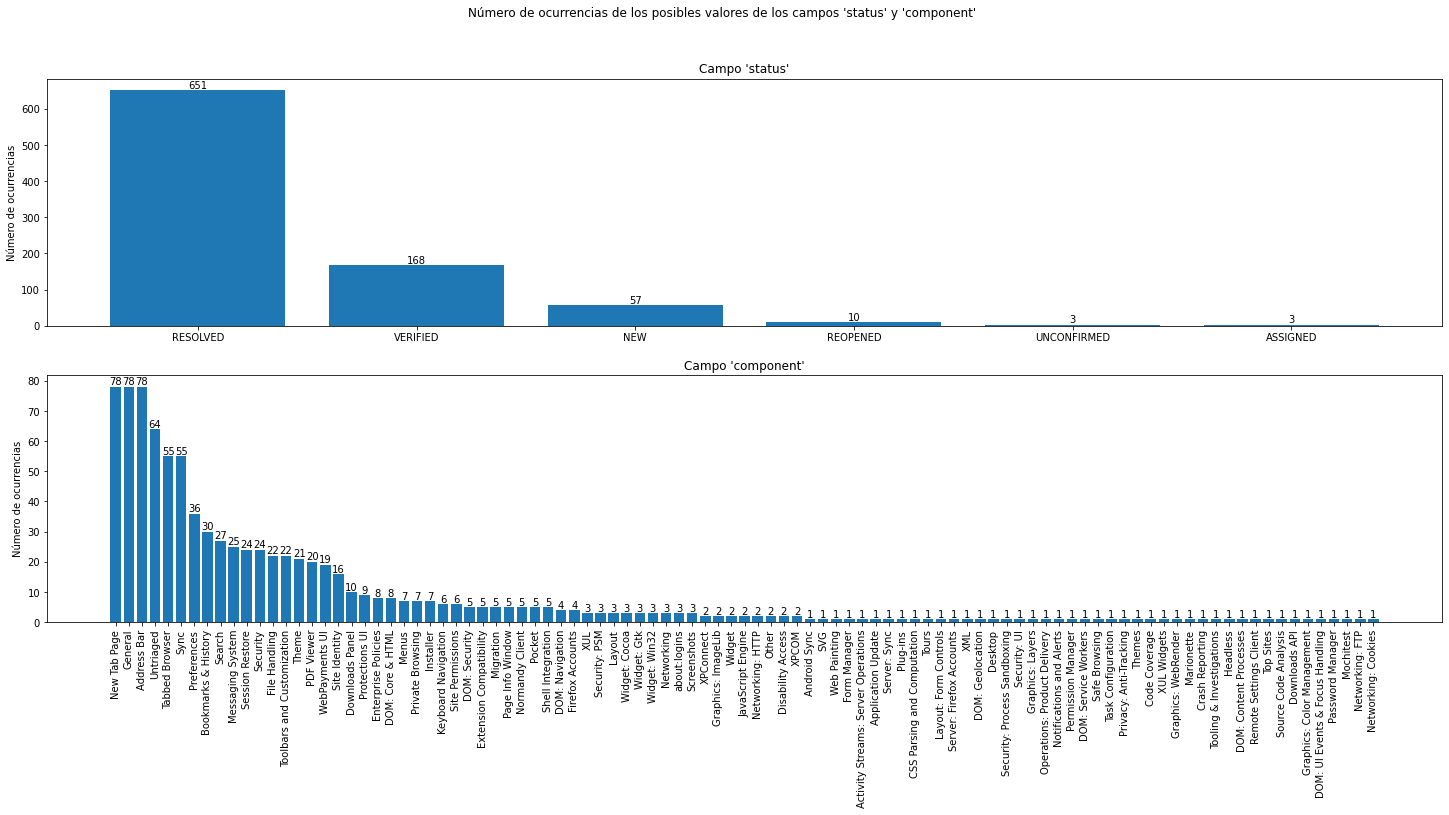

In [175]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 10))
fig.suptitle("Número de ocurrencias de los posibles valores de los campos 'status' y 'component'")

x1_axis = df_reports['status'].value_counts().index
y1_axis = df_reports['status'].value_counts().values
ax1.bar(x1_axis, y1_axis)
ax1.set_title("Campo 'status'")
ax2.set_xticklabels(x1_axis, rotation=90)
ax1.set_ylabel('Número de ocurrencias')
for i, v in enumerate(y1_axis):
    ax1.text(i, v, str(v), color='black', ha='center', va='bottom')


x2_axis = df_reports['component'].value_counts().index
y2_axis = df_reports['component'].value_counts().values
ax2.bar(x2_axis, y2_axis)
ax2.set_title("Campo 'component'")
ax2.set_xticklabels(x2_axis, rotation=90)
ax2.set_ylabel('Número de ocurrencias')
for i, v in enumerate(y2_axis):
    ax2.text(i, v, str(v), color='black', ha='center', va='bottom')

plt.show()

## Campos de texto 'summary' y 'comments'

### Longitudes de los textos

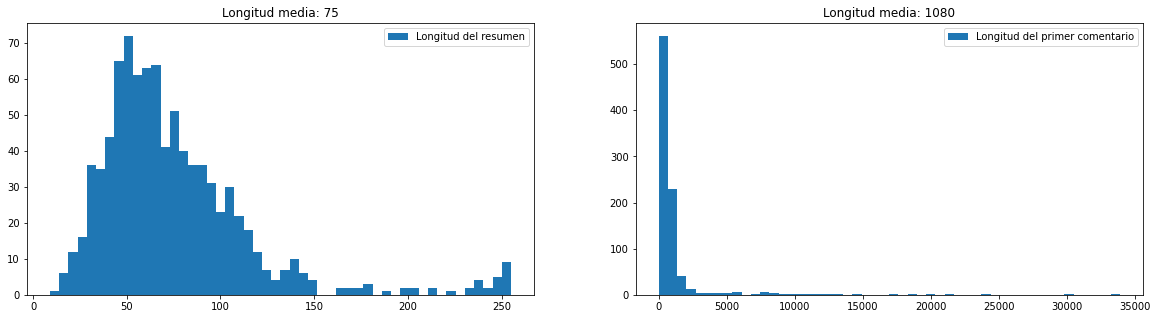

In [152]:
df_reports['len_summary'] =  [len(s) for s in df_reports['summary']]
df_reports['len_comments'] = [len(s) for s in df_reports['comments']]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.hist(df_reports['len_summary'], bins=50, label='Longitud del resumen')
ax1.legend()
ax1.set_title(f"Longitud media: {int(df_reports['len_summary'].mean())}")

ax2.hist(df_reports['len_comments'], bins=50, label='Longitud del primer comentario')
ax2.legend()
ax2.set_title(f"Longitud media: {int(df_reports['len_comments'].mean())}")

plt.show()

In [153]:
df_reports['len_summary'].describe()

count    892.000000
mean      75.569507
std       42.038845
min        9.000000
25%       49.000000
50%       66.000000
75%       91.000000
max      255.000000
Name: len_summary, dtype: float64

In [154]:
df_reports['len_comments'].describe()

count      892.000000
mean      1080.295964
std       2667.651338
min          0.000000
25%        295.000000
50%        532.000000
75%        874.000000
max      33904.000000
Name: len_comments, dtype: float64

#### Valores anómalos

In [155]:
# print sample of annomalous report lengths
annomalous_summaries = df_reports[df_reports['len_summary'] > 200]['summary']
annomalous_comments = df_reports[df_reports['len_comments'] > 875]['comments']

In [156]:
for a in annomalous_summaries:
    print(a)
    print("\n")

Intermittent <random test> | A promise chain failed to handle a rejection: Component returned failure code: 0x80004002 (NS_NOINTERFACE) [nsIInterfaceRequestor.getInterface] - stack: getFindSelection@chrome://browser/content/preferences/findInPage.js:215:8


Intermittent browser/base/content/test/tabs/browser_origin_attrs_in_remote_type.js | A promise chain failed to handle a rejection: Component returned failure code: 0x80004002 (NS_NOINTERFACE) [nsIInterfaceRequestor.getInterface] - stack: getFindSelection@


Intermittent browser/modules/test/browser/browser_PermissionUI.js | A promise chain failed to handle a rejection: engine is null - stack: _updateURLBarPlaceholder@chrome://browser/content/browser.js:4138:9


Intermittent toolkit/components/httpsonlyerror/tests/browser/browser_errorpage.js | Uncaught exception - at resource://specialpowers/SpecialPowersParent.jsm:1222 - TypeError: can't access property "getActor", browsingContext.currentWindowGlobal is null


Intermittent browser/

In [157]:
for a in annomalous_comments:
    print(a)
    print("\n")

**Filed by:** abutkovits [at] mozilla.com
**Parsed log:** https://treeherder.mozilla.org/logviewer?job_id=351984980&repo=autoland
**Full log:** https://firefox-ci-tc.services.mozilla.com/api/queue/v1/task/A2wK4rtRTGq6a-VLQ0jPpw/runs/0/artifacts/public/logs/live_backing.log

---
```
[task 2021-09-18T11:59:05.820Z] 11:59:05     INFO - TEST-PASS | toolkit/components/antitracking/test/browser/browser_contentBlockingAllowListPrincipal.js | Correct origin - 
[task 2021-09-18T11:59:05.821Z] 11:59:05     INFO - Buffered messages finished
[task 2021-09-18T11:59:05.822Z] 11:59:05     INFO - TEST-UNEXPECTED-FAIL | toolkit/components/antitracking/test/browser/browser_contentBlockingAllowListPrincipal.js | A promise chain failed to handle a rejection: Component returned failure code: 0x80004002 (NS_NOINTERFACE) [nsIInterfaceRequestor.getInterface] - stack: getFindSelection@chrome://browser/content/preferences/findInPage.js:215:8
[task 2021-09-18T11:59:05.822Z] 11:59:05     INFO - removeAllSearchInd

In [158]:
print("MEDIDAS ESTADÍSTICAS DE RESÚMENES CON LONGITUDES MUY LARGAS")
# print([len(a) for a in annomalous_summaries])
print(f"Número de reportes: {len(annomalous_summaries)} ({(100*len(annomalous_summaries)/n_reports):.2f}%)")
print(f"Media: {int(np.mean([len(a) for a in annomalous_summaries]))}")
print(f"Cuartiles: {np.percentile([len(a) for a in annomalous_summaries], [25, 50, 75])}")
print(f"Desviación típica: {int(np.std([len(a) for a in annomalous_summaries]))}")
print(f"Máximo: {int(np.max([len(a) for a in annomalous_summaries]))}")
print(f"Mínimo: {int(np.min([len(a) for a in annomalous_summaries]))}")
print()
# print([len(a) for a in annomalous_comments])
print("MEDIDAS ESTADÍSTICAS DE COMENTARIOS CON LONGITUDES MUY LARGAS")
print(f"Número de reportes: {len(annomalous_comments)} ({(100*len(annomalous_comments)/n_reports):.2f}%)")
print(f"Media: {int(np.mean([len(a) for a in annomalous_comments]))}")
print(f"Cuartiles: {np.percentile([len(a) for a in annomalous_comments], [25, 50, 75])}")
print(f"Desviación típica: {int(np.std([len(a) for a in annomalous_comments]))}")
print(f"Máximo: {int(np.max([len(a) for a in annomalous_comments]))}")
print(f"Mínimo: {int(np.min([len(a) for a in annomalous_comments]))}")

MEDIDAS ESTADÍSTICAS DE RESÚMENES CON LONGITUDES MUY LARGAS
Número de reportes: 27 (3.03%)
Media: 240
Cuartiles: [235.5 246.  252.5]
Desviación típica: 15
Máximo: 255
Mínimo: 202

MEDIDAS ESTADÍSTICAS DE COMENTARIOS CON LONGITUDES MUY LARGAS
Número de reportes: 222 (24.89%)
Media: 3089
Cuartiles: [1033.5 1284.5 2234.5]
Desviación típica: 4797
Máximo: 33904
Mínimo: 878


## Wordcloud y tokens más frecuentes

In [159]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /home/ajburri/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [176]:
df_reports['summary_tokens'] = [word_tokenize(s) for s in df_reports['summary']]
df_reports['comments_tokens'] = [word_tokenize(s) for s in df_reports['comments']]

unique_summary_tokens = set([w for s in df_reports['summary_tokens'] for w in s])
unique_comments_tokens = set([w for s in df_reports['comments_tokens'] for w in s])

print(f"Número de tokens únicos en resumen: {len(unique_summary_tokens)}")
print(f"Número de tokens únicos en comentarios: {len(unique_comments_tokens)}")

Número de tokens únicos en resumen: 2874
Número de tokens únicos en comentarios: 14526


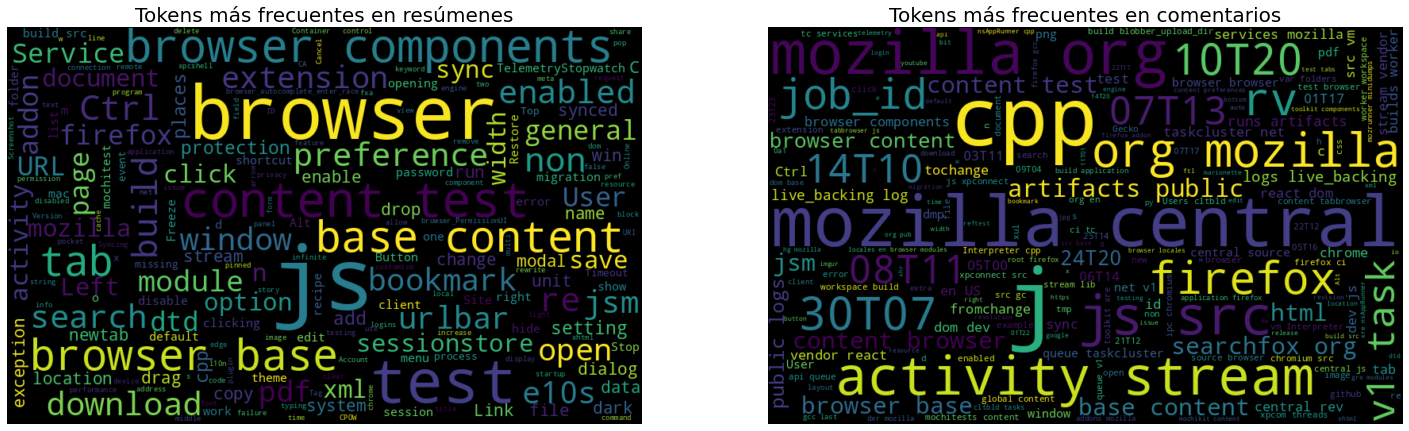

In [177]:
from wordcloud import WordCloud
summary_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(' '.join(unique_summary_tokens))
comments_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(' '.join(unique_comments_tokens))

# Plot in same axis, different graphs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 15))
ax1.imshow(summary_wordcloud, interpolation='bilinear')
ax1.axis("off")
ax1.set_title('Tokens más frecuentes en resúmenes', fontsize=20)
ax2.imshow(comments_wordcloud, interpolation='bilinear')
ax2.axis("off")
ax2.set_title('Tokens más frecuentes en comentarios', fontsize=20)
plt.show()

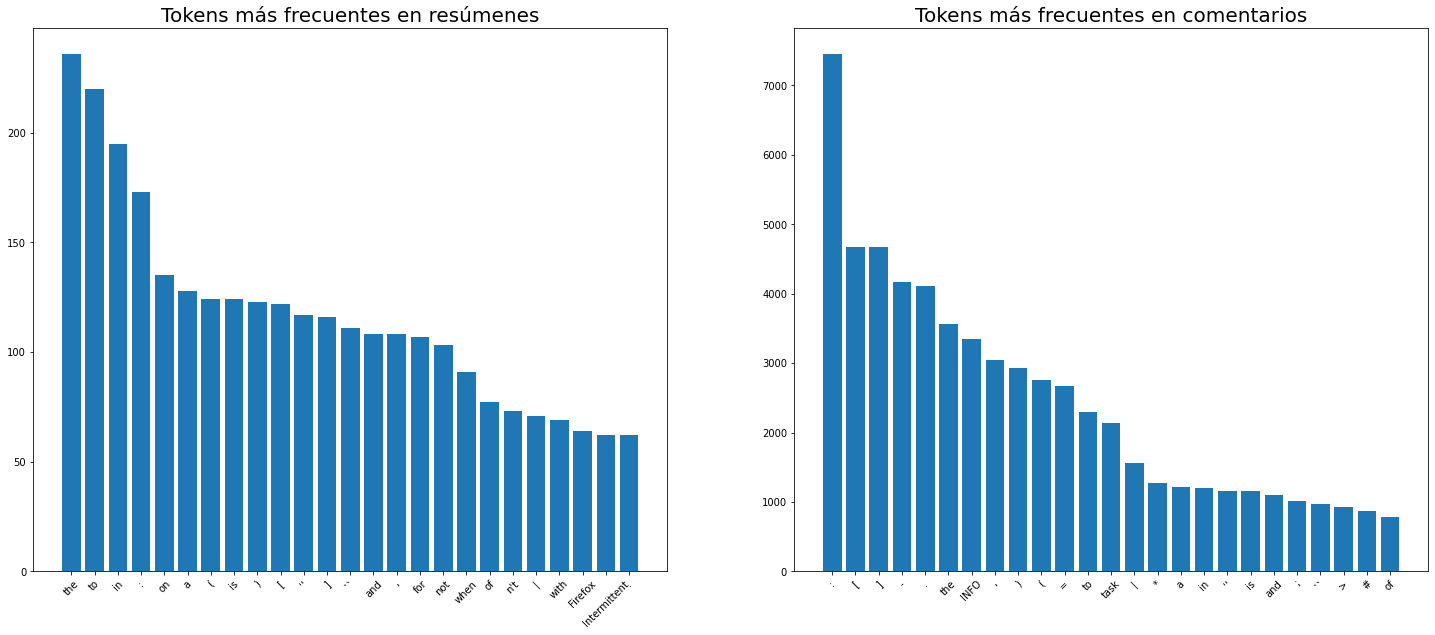

In [178]:
from collections import Counter

summary_counter = Counter(w for s in df_reports['summary_tokens'] for w in s)
comments_counter = Counter(w for s in df_reports['comments_tokens'] for w in s)

summary_counter_25 = summary_counter.most_common(25)
comments_counter_25 = comments_counter.most_common(25)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

ax1.bar(range(len(summary_counter_25)), [count for word, count in summary_counter_25], align='center')
ax1.set_xticks(range(len(summary_counter_25)))
ax1.set_xticklabels([word for word, count in summary_counter_25], rotation=45)
ax1.set_title('Tokens más frecuentes en resúmenes', fontsize=20)

ax2.bar(range(len(comments_counter_25)), [count for word, count in comments_counter_25], align='center')
ax2.set_xticks(range(len(comments_counter_25)))
ax2.set_xticklabels([word for word, count in comments_counter_25], rotation=45)
ax2.set_title('Tokens más frecuentes en comentarios', fontsize=20)

plt.show()